In [44]:
pip install tensorflow

In [1]:
%pylab inline
import numpy as np
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
from numpy import array

Populating the interactive namespace from numpy and matplotlib


<ipython-input-1-4198e280d62f>:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


# Import data

<Figure size 432x288 with 0 Axes>

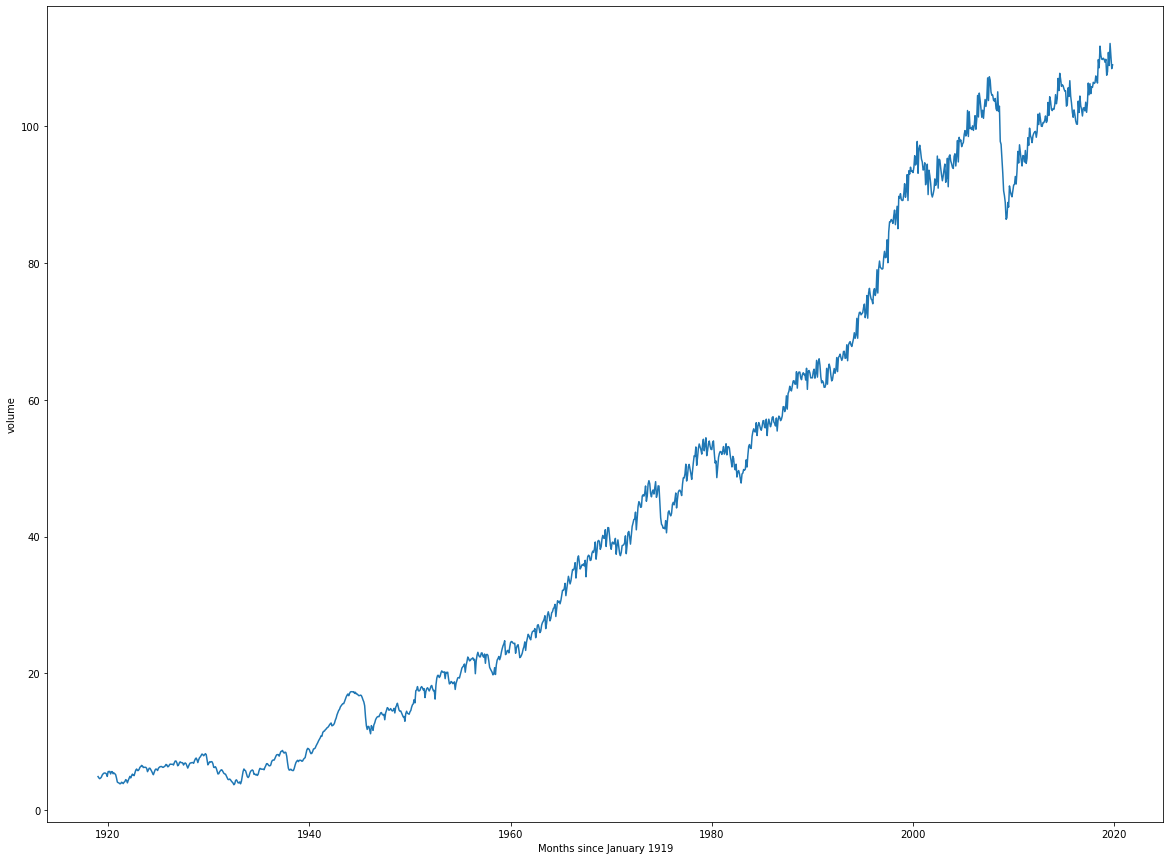

In [2]:
# Data
data = pd.read_csv('./IPB50001N.csv', index_col=['date'], parse_dates=['date'], dayfirst=True,encoding='cp1251')
data = pd.DataFrame(data.value)
fig = plt.figure()
plt.figure(figsize=(20,15))
plt.plot(data)
plt.ylabel('volume')
plt.xlabel('Months since January 1919')
fig.autofmt_xdate()
plt.show()

# Multi-step LSTM 

In [3]:
# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # входящая последовательность (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # прогнозируемая последовательность (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# train / test splitting
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

In [4]:
# trajectory matrix
d1 = series_to_supervised(data, n_in=5, n_out=7, dropnan=True)
d1

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
date,,,,,,,,,,,,
1919-06-01,4.9286,4.7348,4.6240,4.7071,4.8455,5.1501,5.3162,5.4270,5.4547,5.4270,5.3162,4.9563
1919-07-01,4.7348,4.6240,4.7071,4.8455,5.1501,5.3162,5.4270,5.4547,5.4270,5.3162,4.9563,5.6485
1919-08-01,4.6240,4.7071,4.8455,5.1501,5.3162,5.4270,5.4547,5.4270,5.3162,4.9563,5.6485,5.6762
1919-09-01,4.7071,4.8455,5.1501,5.3162,5.4270,5.4547,5.4270,5.3162,4.9563,5.6485,5.6762,5.6762
1919-10-01,4.8455,5.1501,5.3162,5.4270,5.4547,5.4270,5.3162,4.9563,5.6485,5.6762,5.6762,5.3162
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01,111.6802,110.3348,109.7840,109.7341,109.9156,109.7224,109.3189,109.7620,107.4294,107.9400,110.7628,108.8527
2019-02-01,110.3348,109.7840,109.7341,109.9156,109.7224,109.3189,109.7620,107.4294,107.9400,110.7628,108.8527,112.0720
2019-03-01,109.7840,109.7341,109.9156,109.7224,109.3189,109.7620,107.4294,107.9400,110.7628,108.8527,112.0720,110.0913


In [5]:
# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    
    # stateful = True - keep state in memory;
    
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        print(i)
        hist = model.fit(X, y, validation_split=0.1,epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    return model,history_loss,history_val_loss

# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]
 
# Forecasting
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

# обратная разность
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
 
# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

In [6]:
# hyperparameters initialization and training the model
n_lag = 36
n_seq =240
n_test = 240
n_epochs = 30
n_batch = 1
n_neurons =  8

scaler, train, test = prepare_data(data, n_test, n_lag, n_seq)

model,history_loss,history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

forecasts = inverse_transform(data, forecasts, scaler, n_test+2)


0
625/625 [==============================] - 5s 4ms/step - loss: 0.0233 - val_loss: 0.0535
1
625/625 [==============================] - 2s 3ms/step - loss: 0.0177 - val_loss: 0.0368
2
625/625 [==============================] - 2s 3ms/step - loss: 0.0139 - val_loss: 0.0304
3
625/625 [==============================] - 2s 3ms/step - loss: 0.0127 - val_loss: 0.0270
4
625/625 [==============================] - 2s 3ms/step - loss: 0.0119 - val_loss: 0.0250
5
625/625 [==============================] - 2s 3ms/step - loss: 0.0116 - val_loss: 0.0244
6
625/625 [==============================] - 2s 3ms/step - loss: 0.0115 - val_loss: 0.0242
7
625/625 [==============================] - 2s 3ms/step - loss: 0.0114 - val_loss: 0.0240
8
625/625 [==============================] - 2s 3ms/step - loss: 0.0113 - val_loss: 0.0238
9
625/625 [==============================] - 2s 3ms/step - loss: 0.0112 - val_loss: 0.0237
10
625/625 [==============================] - 2s 3ms/step - loss: 0.0112 - val_loss: 0.023

1/1 [==============================] - 0s 16ms/step


In [7]:
forecast_list = []

for v in forecasts[0]:
    #print(v[0])
    forecast_list.append(v[0])

In [8]:
data_lstm_forecast = data.iloc[971:,:]
data_lstm_forecast['forecast_LSTM']=forecast_list

<ipython-input-8-43f52207122b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_lstm_forecast['forecast_LSTM']=forecast_list


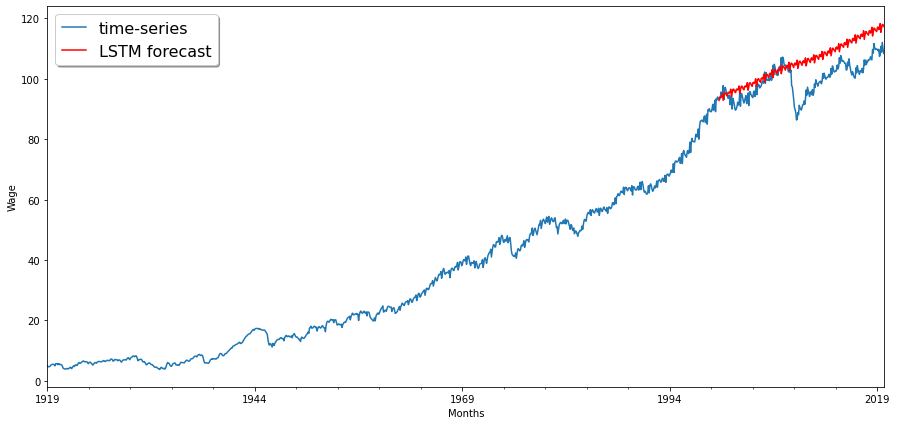

In [9]:
# visualize
plt.figure(figsize(15,7))
data.value.plot()

data_lstm_forecast.forecast_LSTM.plot(color='r')


plt.ylabel('Wage')
plt.xlabel('Months')

plt.legend(('time-series', 'LSTM forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)
plt.show()


[0.010522618889808655] [0.023344650864601135]


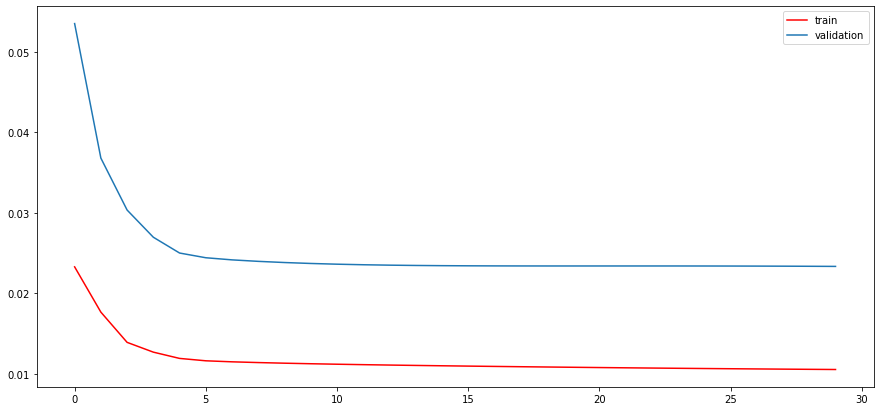

In [10]:
# Loss functions for val and train sets
plt.plot(history_loss, 'r',label='train')
plt.plot(history_val_loss,label='validation')
plt.legend()
print(history_loss[-1],history_val_loss[-1])

In [11]:
data_lstm_forecast

,value,forecast_LSTM
date,,
1999-12-01,93.4379,92.830119
2000-01-01,93.2009,93.939636
2000-02-01,93.9853,94.049679
2000-03-01,95.6647,93.809721
2000-04-01,94.3101,94.310252
...,...,...
2019-07-01,108.8527,116.888700
2019-08-01,112.0720,118.013406
2019-09-01,110.0913,117.949170


In [12]:
y = data_lstm_forecast.iloc[:,0] #y
y_lstm = data_lstm_forecast.iloc[:,1] #y

In [15]:
from sklearn.metrics import r2_score

print("LSTM R2 score:",round(r2_score(y,y_lstm),3))

LSTM R2 score: -0.786


In [199]:
def mean_absolute_percentage_error(y_true,y_pred):
    return round(np.mean(np.abs((y_true-y_pred)/y_true))*100,3)

print("LSTM MAPE:",mean_absolute_percentage_error(y,y_lstm))

LSTM MAPE: 6.3


# ARIMA

In [152]:
# let's import necassary packages...
%pylab inline
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


Dickey-Fuller test: p=0.996833


<Figure size 1080x720 with 0 Axes>

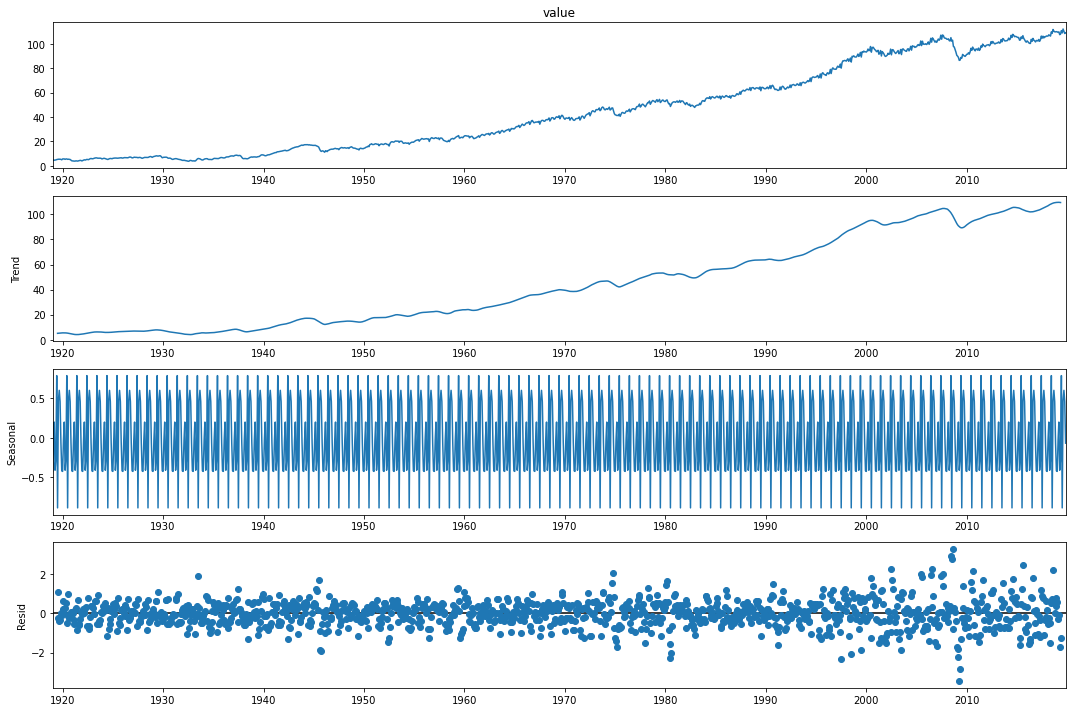

In [153]:
# evaluate sm.tsa.seasonal_decompose(data.value).plot()
# evaluate Dickey-Fuller test for time-series stationarity
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.value).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data.value)[1])

In [154]:
data_arima = data.iloc[:971]

Best Box-Cox parameter: 0.195856
Dickey-Fuller test: p=0.954141


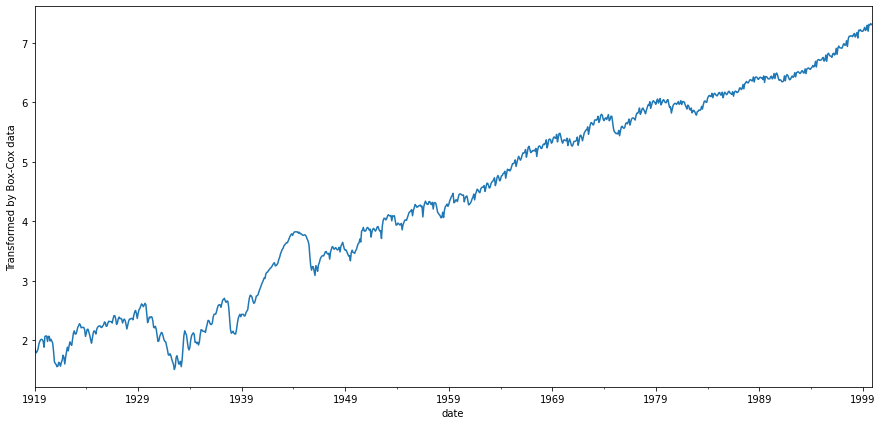

In [155]:
# Box-Cox transformation for dispersion stationarity
data_arima['value_box'], lmbda = stats.boxcox(data_arima.value)
plt.figure(figsize(15,7))
data_arima.value_box.plot()
plt.ylabel('Transformed by Box-Cox data')
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_arima.value_box)[1])

Dickey-Fuller test: p=0.000000


<Figure size 1080x720 with 0 Axes>

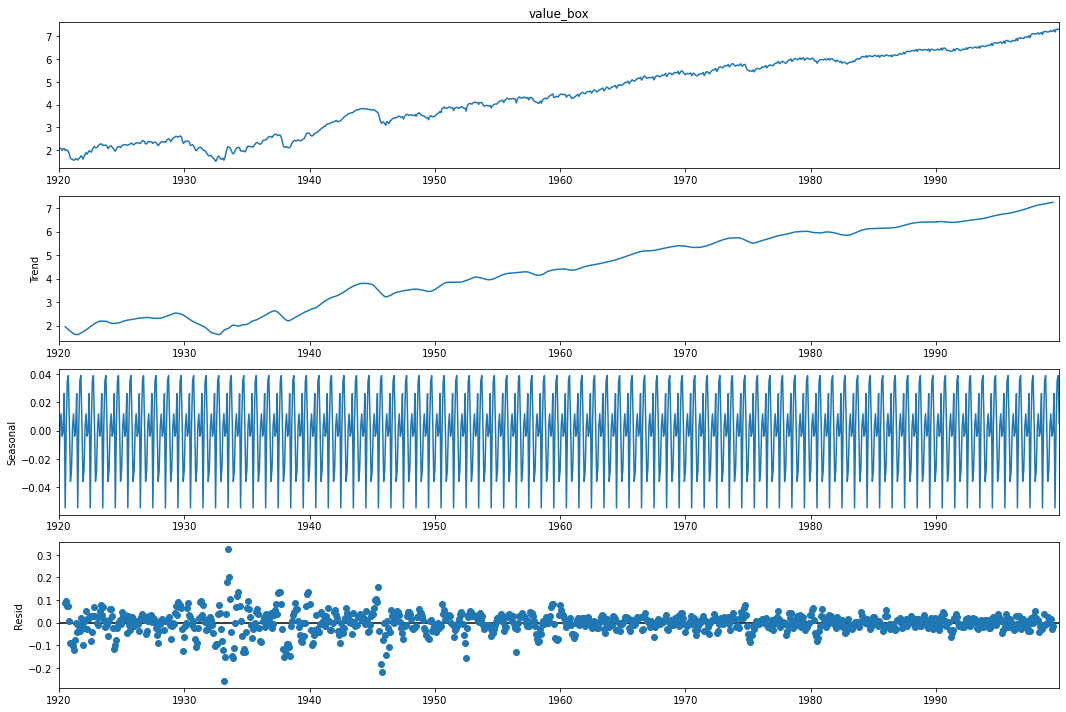

In [156]:
# seasonal difference for 12 months
data_arima['value_box_diff'] = data_arima.value_box - data_arima.value_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data_arima.value_box[12:]).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(data_arima.value_box_diff[12:])[1])

Dickey-Fuller test: p=0.000000000000048


<Figure size 1080x720 with 0 Axes>

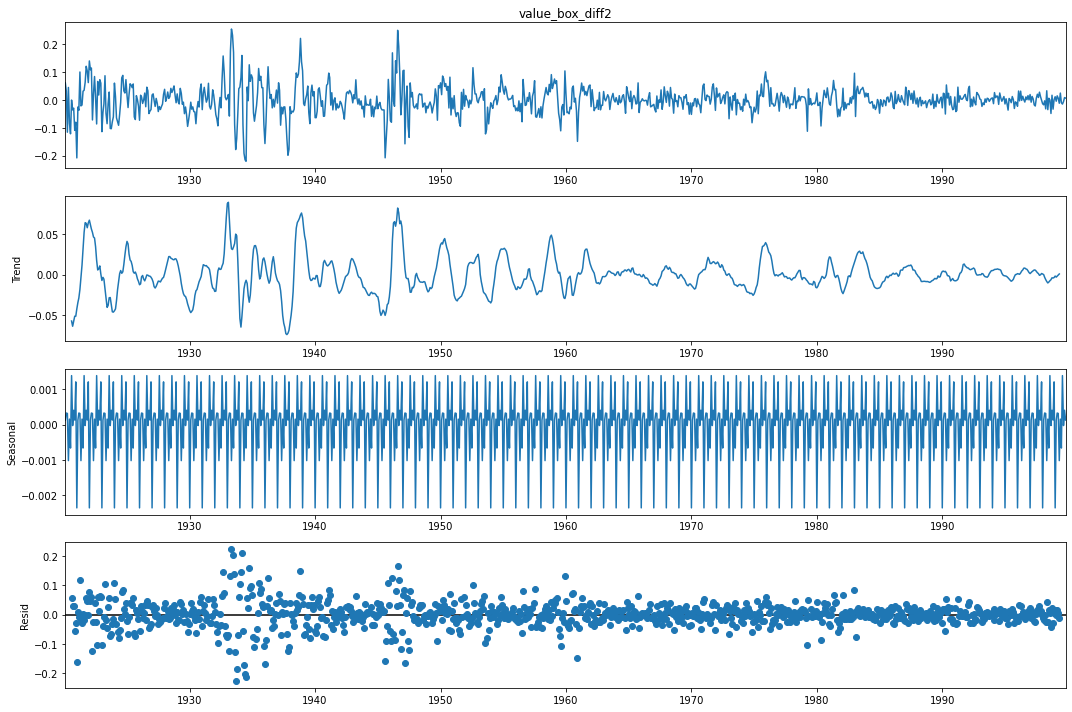

In [157]:
# additional 1-step difference
data_arima['value_box_diff2'] = data_arima.value_box_diff - data_arima.value_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data_arima.value_box_diff2[13:]).plot()
print("Dickey-Fuller test: p=%.15f" % sm.tsa.stattools.adfuller(data_arima.value_box_diff2[13:])[1])

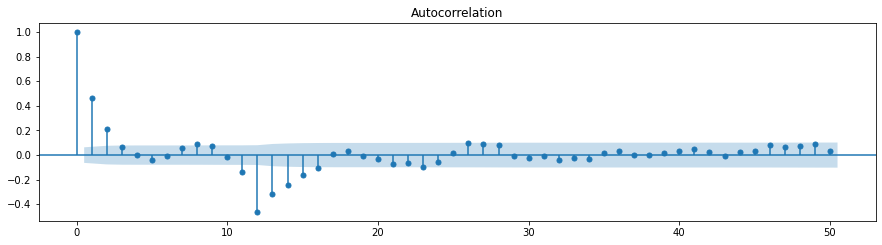

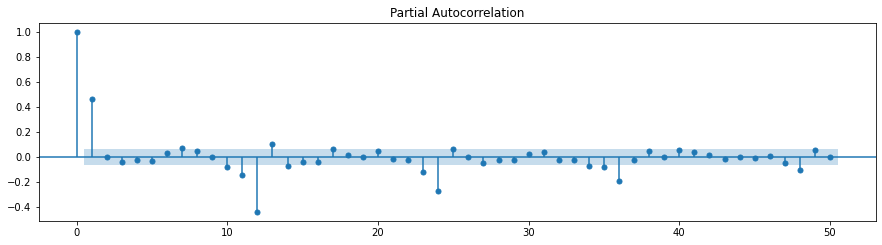

In [158]:
# let's calculate autocorrelation and partial autocorrelation components
plt.figure(figsize(15,8))

# autocorrelation 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_arima.value_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_arima.value_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

In [159]:
# parameters for SARIMA model
# better use values < 10
# p and P - show how many autoregressive (AR) terms for non-seasonal (p) and Seasonal (P) component do we want to use
# q and Q - show how many moving average (MA) terms for non-seasonal (q) and Seasonal (Q) component do we want to use
# d - show how many times have we derivated our series 1-step-wise
# D - show how many times have we derivated our series Period-step-wise

ps = range(0, 6)   # 5 
d = 1
qs = range(0, 6)  # 5
Ps = range(0, 2)  # 1
D = 1
Qs = range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 72


In [160]:
results = []
best_aic = float("inf")

# ignore warnings 
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(data1.value_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #print(aic)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
        #print(results)
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())     

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

     parameters          aic
5  (1, 0, 1, 0) -3464.659689
4  (0, 3, 1, 0) -3462.086909
3  (0, 2, 1, 0) -3461.201634
2  (0, 1, 1, 0) -3434.730526
1  (0, 0, 1, 0) -3244.727782


In [161]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters          aic
5  (1, 0, 1, 0) -3464.659689
4  (0, 3, 1, 0) -3462.086909
3  (0, 2, 1, 0) -3461.201634
2  (0, 1, 1, 0) -3434.730526
1  (0, 0, 1, 0) -3244.727782


In [162]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          value_box   No. Observations:                  970
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                1735.330
Date:                            Thu, 29 Sep 2022   AIC                          -3464.660
Time:                                    00:03:42   BIC                          -3450.068
Sample:                                01-01-1919   HQIC                         -3459.102
                                     - 10-01-1999                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4550      0.018     25.459      0.000       0.420       0.490
ar.S.L12      -0.4681      0.017   

Student test: p=0.958540
Dickey-Fuller test: p=0.0000000000000000031467939


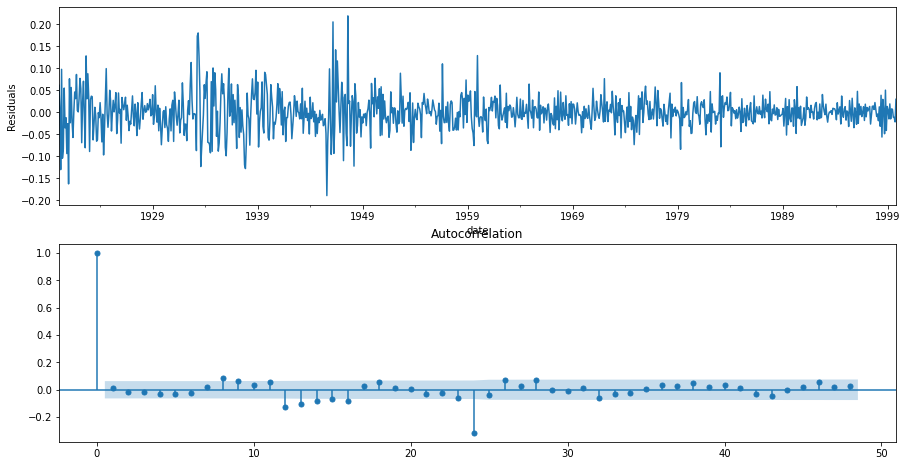

In [163]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

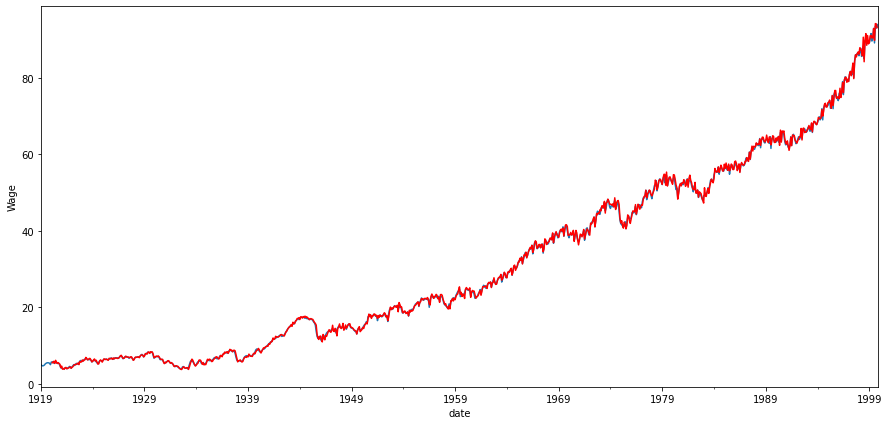

In [165]:
#inverse Box-Cox transformation:

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)
    
data_arima['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data_arima.value.plot()
data_arima.model[13:].plot(color='r')
plt.ylabel('Wage')
pylab.show()



In [173]:
data_arima.iloc[970,:]

value              93.363000
value_box           7.308834
value_box_diff      0.109025
value_box_diff2     0.007087
model                    NaN
Name: 1999-11-01 00:00:00, dtype: float64

In [168]:
data_arima

,value,value_box,value_box_diff,value_box_diff2,model
date,,,,,
1919-01-01,4.9286,1.872308,NaN,NaN,1.000000
1919-02-01,4.7348,1.817697,NaN,NaN,4.930742
1919-03-01,4.6240,1.785662,NaN,NaN,4.736760
1919-04-01,4.7071,1.809745,NaN,NaN,4.625859
1919-05-01,4.8455,1.849106,NaN,NaN,4.709035
...,...,...,...,...,...
1999-07-01,89.1196,7.196246,0.113434,-0.009924,89.787817
1999-08-01,93.4669,7.311539,0.098833,-0.014600,94.181639
1999-09-01,92.9823,7.298903,0.093213,-0.005620,94.090531


In [205]:
data_arima_forecast = data[['value']]
date_list = [datetime.datetime.strptime("1999-11-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,240)]
future = pd.DataFrame(index=date_list, columns= data_arima_forecast.columns)
data_arima_forecast = pd.concat([data_arima_forecast, future])
data_arima_forecast['forecast'] = invboxcox(best_model.predict(start=970, end=1211), lmbda)


y = data_arima_forecast.iloc[971:1211,0] #y
y_sma = data_arima_forecast.iloc[971:1211,1] #y

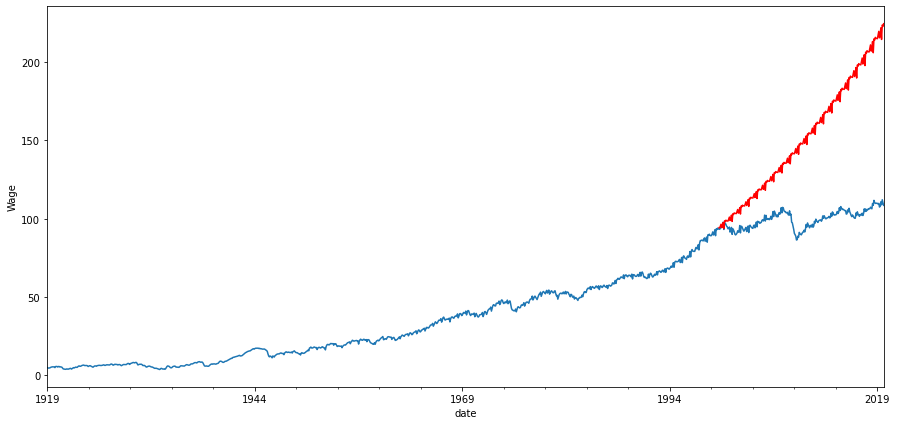

In [206]:
plt.figure(figsize(15,7))
data.value.plot()
y_sma.plot(color='r')
plt.ylabel('Wage')
pylab.show()

# R2 metric for ARIMA model

In [208]:
from sklearn.metrics import r2_score

print("ARIMA R2 score:",round(r2_score(y,y_sma),3))

ARIMA R2 score: -114.995


In [209]:
def mean_absolute_percentage_error(y_true,y_pred):
    return round(np.mean(np.abs((y_true-y_pred)/y_true))*100,3)

print("ARIMA MAPE:",mean_absolute_percentage_error(y,y_sma))

ARIMA MAPE: 50.926


# Comparing models

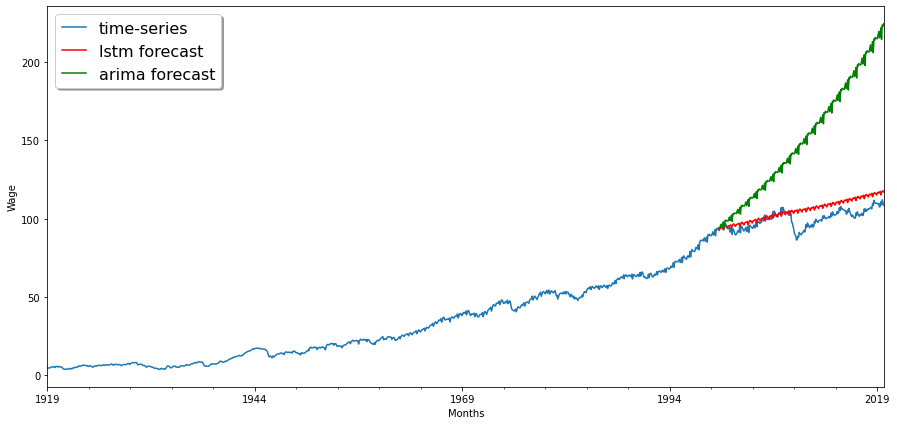

In [211]:
# visualize
plt.figure(figsize(15,7))
data.value.plot()

data_lstm_forecast.forecast_LSTM.plot(color='r')

y_sma.plot(color='g')

plt.ylabel('Wage')
plt.xlabel('Months')

plt.legend(('time-series', 'lstm forecast','arima forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)
plt.show()


# Conclusions

From the model comparison graph, it can be seen that the LSTM model showed more accurate predictive values ​​to real ones compared to the ARIMA model, this can also be done by comparing the R2-square and MAPE metrics.